# Spotify Listening History Analysis
*Learning Project*

Using my spotify data from august 2024 to august 2025, i tried to get handy outcome such

**What information i will try to gather**

Top 10 most listened songs by the milliseconds played  
Top 10 most skipped tracks  
Top 10 most skipped tracks that was skipped after 50% of song was played and which percent this songs was skipped the most  
Build a map of every place where i listened music using ip adresses  
Most listened tracks in a period of time with slicers for months  

**Expectations for this project**

To practice data cleaning, transformation, importing raw JSON files into SQL, writing queries on SQL, window functions, simple Power BI charts with maximum information, data transformation in Power Query and a little Python

**Data description**

ts – timestamp with time zone (example: 2025-08-24 22:39:13+05)  
platform – device that played music (android or pc in my case)  
ms_played – milliseconds the track was played during a specific session  
conn_country – country where song was played  
ip_address – ipv4 and ipv6 addresses where song was played  
track_name – name of the song  
artist_name – name of the artist  
album_name – name of the album  
spotify_track_uri – unique Spotify identifier (URI) for the track  
skipped – boolean that indicates whether the song was skipped or not  
reason_start – which way the song was turned on  
reason_end – which way the song was turned off  
shuffle – boolean that indicates whether shuffle mode was enabled  
offline – boolean that indicates whether the song was played in offline mode or not  
offline_timestamp – Unix timestamp of synchronization time for offline plays  
incognito_mode – boolean that indicates whether the song was played in incognito mode or not  


**Start of the project**

Finally i get my data from spotify and instantly started thinking how to import JSON file into postgreSQL. For this purpose i choose Python psycopg2, json and glob libraries

After loading data to PostgreSQL, i made raw data table with jsonb

In [ ]:
import psycopg2, json, glob

# With this command i connected to the database
conn = psycopg2.connect(
    dbname="musicpet",
    user="postgres",
    password="1234",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

# Then i looked for my json file
for f in glob.glob(r"C:\Users\aibat\Downloads\my_spotify_data\SpotifyExtendedStreamingHistory\*.json"):
    with open(f, encoding="utf-8") as infile:
        data = json.load(infile)  #
        cur.execute("INSERT INTO raw_json (data) VALUES (%s)", [json.dumps(data)])

conn.commit()
cur.close()
conn.close()
print("Well Done, files inserted!")

In [ ]:
CREATE TABLE raw_json (
    data jsonb NOT NULL
);

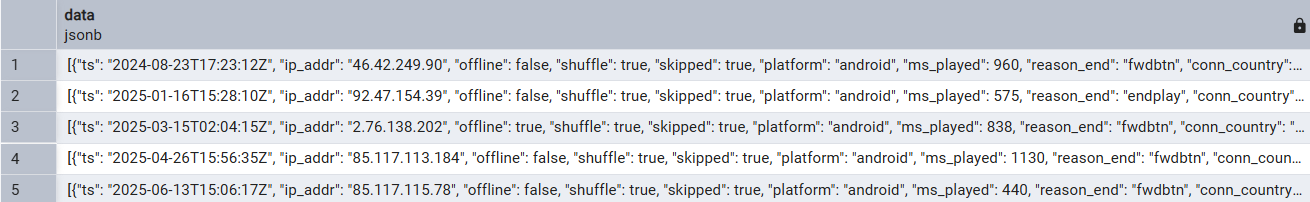

And when raw data is ready i create main table

In [ ]:
CREATE TABLE streaming_history (
    ts                timestamptz NOT NULL,
    platform          text,
    ms_played         bigint      NOT NULL,
    conn_country      text,
    ip_address        text,
    track_name        text,
    artist_name       text,
    album_name        text,
    spotify_track_uri text,
    skipped           boolean,
    reason_start      text,
    reason_end        text,
    shuffle           boolean,
    offline           boolean,
    offline_timestamp bigint,
    incognito_mode    boolean
);

-- 3) Загрузка данных из raw_json в streaming_history
INSERT INTO streaming_history (
    ts, platform, ms_played, conn_country, ip_address,
    track_name, artist_name, album_name, spotify_track_uri,
    skipped, reason_start, reason_end, shuffle,
    offline, offline_timestamp, incognito_mode
)
SELECT
    (elem->>'ts')::timestamptz,
    elem->>'platform',
    (elem->>'ms_played')::bigint,
    elem->>'conn_country',
    elem->>'ip_addr',                            
    elem->>'master_metadata_track_name',
    elem->>'master_metadata_album_artist_name',
    elem->>'master_metadata_album_album_name',
    elem->>'spotify_track_uri',
    (elem->>'skipped')::boolean,
    elem->>'reason_start',
    elem->>'reason_end',
    (elem->>'shuffle')::boolean,
    (elem->>'offline')::boolean,
    (elem->>'offline_timestamp')::bigint,
    (elem->>'incognito_mode')::boolean
FROM raw_json,
     LATERAL jsonb_array_elements(data) AS elem;

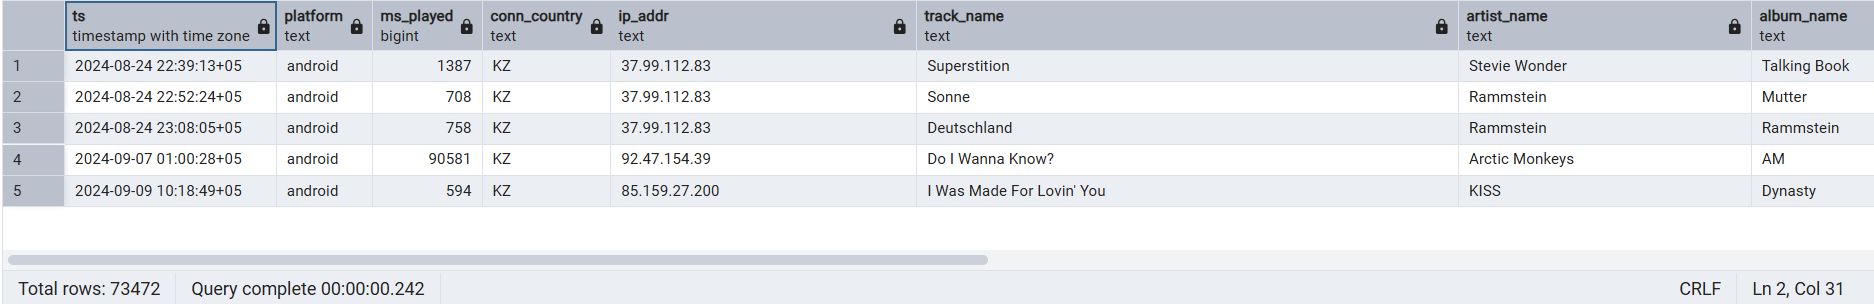

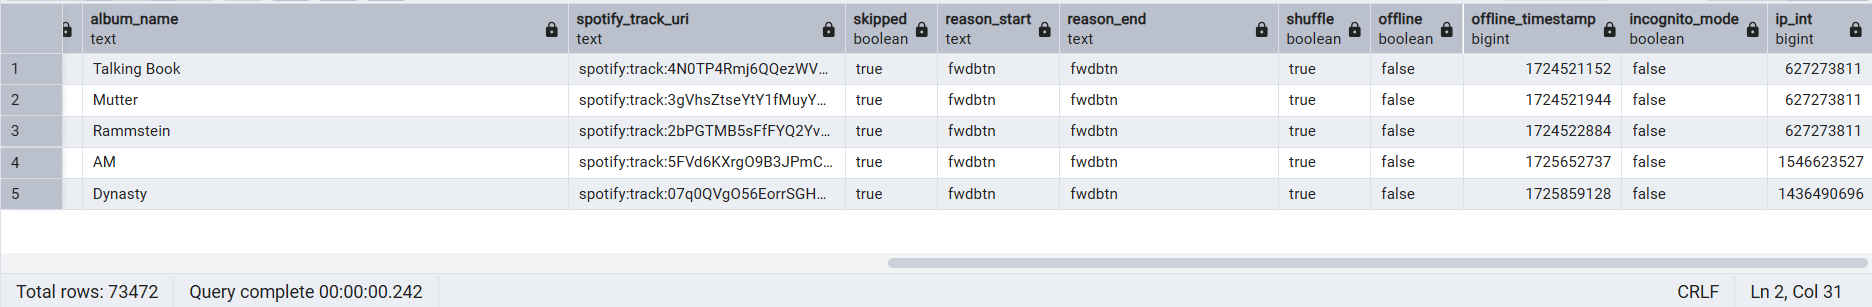

*Comment:* Limited to 5 rows

# First Query
**Top 10 most listened songs by milliseconds**

In [ ]:
 SELECT artist_name,
    track_name,
    round(sum(ms_played) / 3600000::numeric, 2) AS hours
   FROM streaming_history
  GROUP BY artist_name, track_name
  ORDER BY (round(sum(ms_played) / 3600000::numeric, 2)) DESC
 LIMIT 10;

![Raw JSON table](Screenshots/s1.png)

**Functions used:** Round, Group By, Date Type Conversion

**Insight:**  We see that the most listened song of all time is Hotel California with the total hours of 6.70

**Final Graph:**

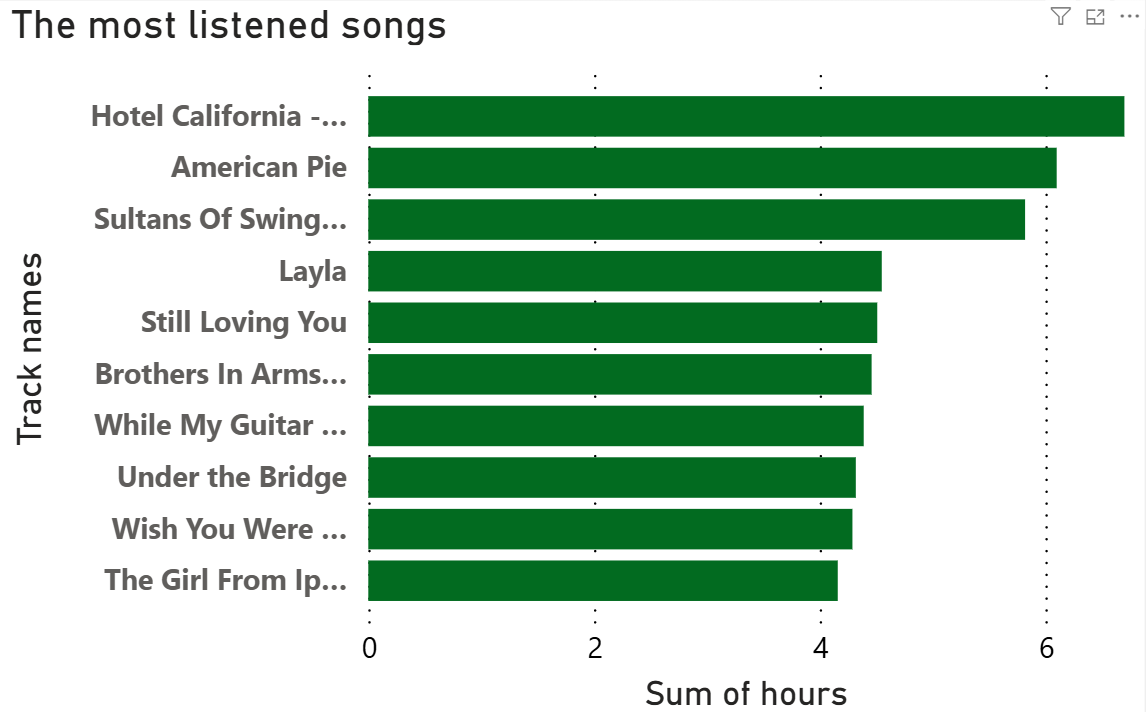

*Comment:* This query doesnt require complicated graph, so i decided to use clustered bar chart. Its simple, but handy and minimalistic

# Second Query
**Top 10 most skipped tracks**

In [ ]:
 SELECT artist_name,
    track_name,
    count(skipped) AS count
   FROM streaming_history
  GROUP BY artist_name, track_name
  ORDER BY (count(skipped)) DESC
 LIMIT 10;

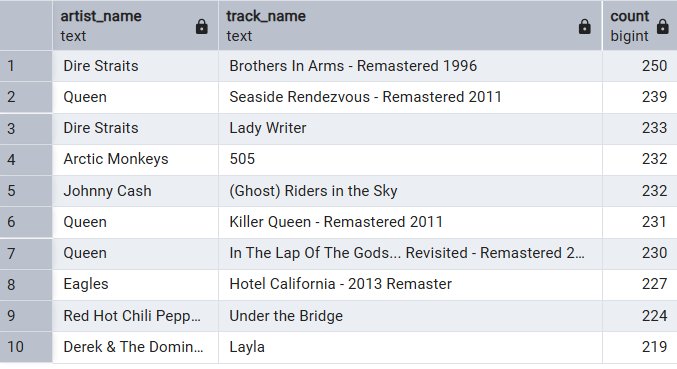

**Functions used:** Group By, Count, Limit

**Insight:** The most skipped authors are Dire Straits and Queen. Especially songs Brothers in Arms and Seaside Rendezvous

**Final Graph:**

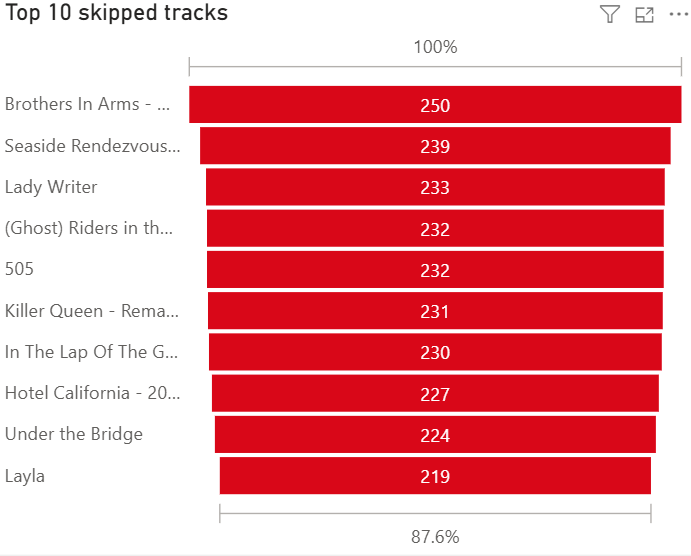

*Comment:* Funnel is a great choice for this kind of query. And red color showcases that its more like negative indicator

# Third Query
**Top 10 most skipped tracks that was skipped after 50% of song was played and which percent this songs was skipped the most**

In [ ]:
 SELECT track_name,
    percent,
    count AS play_number
   FROM ( SELECT percentlistened.track_name,
            percentlistened.percent,
            count(*) AS count,
            row_number() OVER (PARTITION BY percentlistened.track_name ORDER BY (count(*)) DESC) AS e
           FROM percentlistened
          GROUP BY percentlistened.track_name, percentlistened.percent) unnamed_subquery
  WHERE e = 1 AND percent >= 50::numeric AND percent <= 90::numeric
  ORDER BY count DESC
 LIMIT 10;

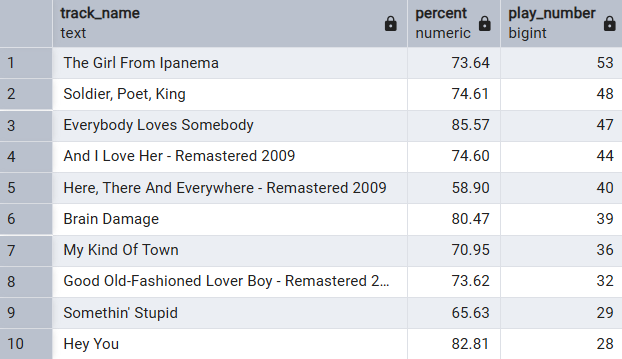

**Functions used:** Count, Group By, Window Function, Subquery

**Insight**: Most of the time i skip "Thee Girl From Ipanema" on 73.64% of the song. There must be bad part of the song or the part was boring

**Final Graph:**

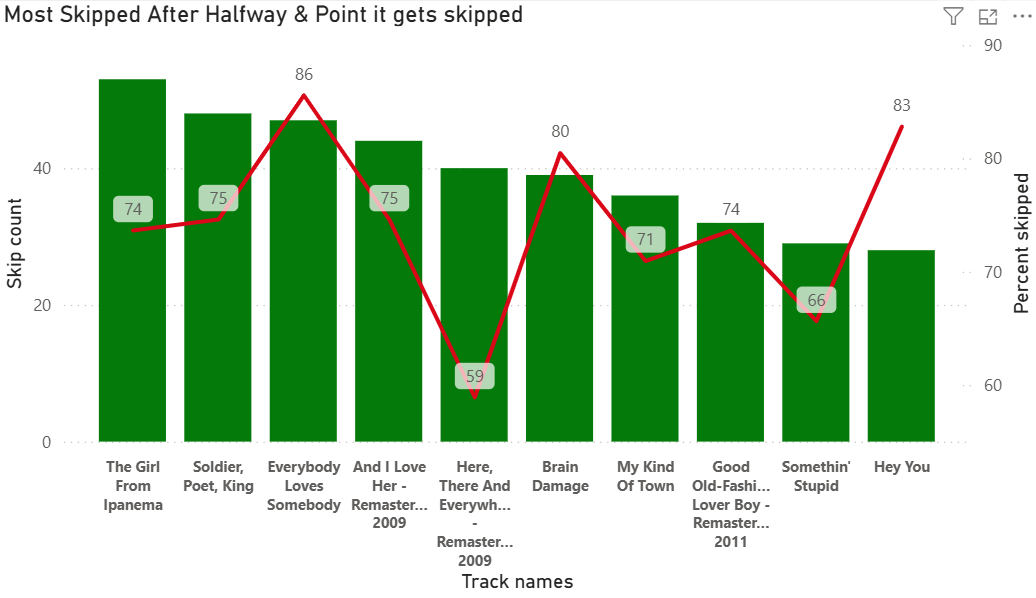

*Comment:* I choosed line and stucked column chart because its perfect when it comes to dealing with 3 variables. I made skip counts unvisible, so the percents skipped was cleaner

# Fourth Query(Failure)
**Build a map of every place where i listened music using ip adresses**
To build this graph i need to prepare data. My database has ip_addresses, but not latitude and longitude to build the map. So i downloaded the database from 'https://db-ip.com/db/download/ip-to-city-lite'. Using this database i can traverse ip adresses to lati/longi. But to transfer it, i need to get integers of ip

In [9]:
# So firstly i need to create column for integer
ALTER TABLE streaming_history ADD COLUMN ip_int int

# Then i can fill it up. With string_to_array i take parts of ip divided by point
UPDATE streaming_history
SET ip_int = 
  (string_to_array(ip_addr, '.'))[1]::int * 256^3 + 
  (string_to_array(ip_addr, '.'))[2]::int * 256^2 + 
  (string_to_array(ip_addr, '.'))[3]::int * 256 + 
  (string_to_array(ip_addr, '.'))[4]::int;

# There i interfere an error because ipv6 was so long that it couldn't be fit in 64-bit integer
# There was only 1-5% of ipv6 and the 95-99% was ipv4, so i decided to filter out ipv6
UPDATE streaming_history
SET ip_int = 
  (string_to_array(ip_addr, '.'))[1]::int * 256^3 + 
  (string_to_array(ip_addr, '.'))[2]::int * 256^2 + 
  (string_to_array(ip_addr, '.'))[3]::int * 256 + 
  (string_to_array(ip_addr, '.'))[4]::int
WHERE ip_addr NOT LIKE '%:%';

Now i need to import downloaded ip database in PostgreSQL

In [ ]:
CREATE TABLE ip_database (
    ip_from text,
    ip_to text,
    continent text,
    country text,
    region text,
    city text,
    latitude numeric,
    longitude numeric
);

At first i tried this command in psql, but got error
\copy ip_database (ip_from, ip_to, continent, country, region, city, latitude, longitude) 
FROM 'C:/Users/aibat/Downloads/dbip-city-lite-2025-08.csv' DELIMITER ',' CSV HEADER;

ERROR: unterminated CSV quoted field CONTEXT: COPY ip_database, line 7958526: "5.3.80.0,5.3.81.255,EU,RU,"Leningradskaya Oblast'",Kudrovo,59.9027,30.5125 5.3.82.0,5.3.82.255,EU,RU..." psql: error: utility failed with exit code: 1

That error was caused because of internal quotes in fields in the database. PostgreSQL \copy sees the first " → thinks field ends there → parser breaks → “unterminated CSV quoted field”

Python was better option, so instead of psql i switched to python

In [ ]:
import pandas as pd
import ipaddress

# Read CSV and skipped malformed rows
df = pd.read_csv(
    r"C:\dbip-city-lite-2025-08.csv\dbip-city-lite-2025-08.csv",
    header=None, on_bad_lines="skip"
)
df.columns = [
    "ip_start", "ip_end",
    "continent_code", "country_code",
    "region", "city",
    "latitude", "longitude"
]

def ip_to_int(ip):
    try:
        ip_obj = ipaddress.ip_address(ip)
        if ip_obj.version == 4:  # only IPv4
            return int(ip_obj)
        else:
            return None
    except ValueError:
        return None

# Converted the IPs
df["ip_start_int"] = df["ip_start"].apply(ip_to_int)
df["ip_end_int"]   = df["ip_end"].apply(ip_to_int)

# Dropped rows with invalid ints
df = df.dropna(subset=["ip_start_int", "ip_end_int"])

# Forced integers, no "0.0"
df["ip_start_int"] = df["ip_start_int"].astype("int64")
df["ip_end_int"]   = df["ip_end_int"].astype("int64")

# Then saved ready csv
output_path = r"C:\Users\aibat\Documents\dbip_clean.csv"
df.to_csv(output_path, index=False)
print("Saved to:", output_path)

# Then imported this csv to new PostgreSQL table ip_database

In [ ]:
# At the end i only had to join my streaming history ip integers with the ip_database range of ip(ip_from - ip_to) 
SELECT sh.track_name, sh.ip_int
FROM streaming_history sh
JOIN ip_database d
  ON sh.ip_int BETWEEN d.ip_start_int AND d.ip_end_int;

# But just joining was too long, i stopped it when it reached 36 minutes

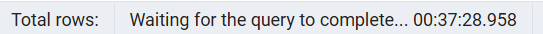

I stopped the project for some time to learn the way to optimize it. The best option i found was to create indexes 

In [ ]:
ALTER TABLE ip_database
  ADD COLUMN ip_range int8range GENERATED ALWAYS AS (int8range(ip_start_int, ip_end_int, '[]')) STORED;

CREATE INDEX idx_ip_range ON ip_database USING gist (ip_range);

# And then the new query
 SELECT sh.track_name, count(ip_addr)
    ip.latitude,
    ip.longitude
   FROM streaming_history sh
     JOIN ip_database ip ON sh.ip_int <@ ip.ip_range;
# Instead of AND i used <@ which means element belongs to range

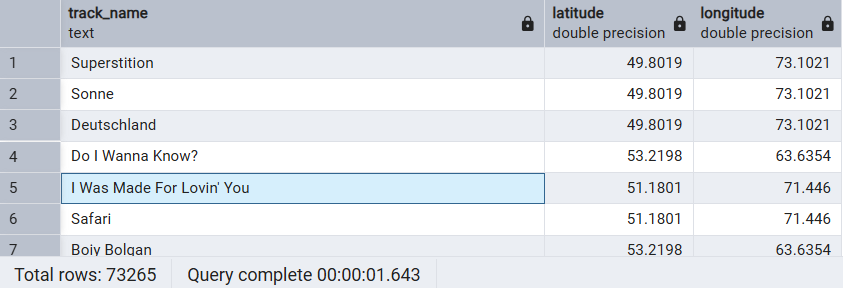

Now when i have latitude and longitude for all sessions when song was played i can build a map. Let's move to Power BI
**Tools used:** string_to_array, pandas, Inner Join, indexes, join on range
**Final Graph:**

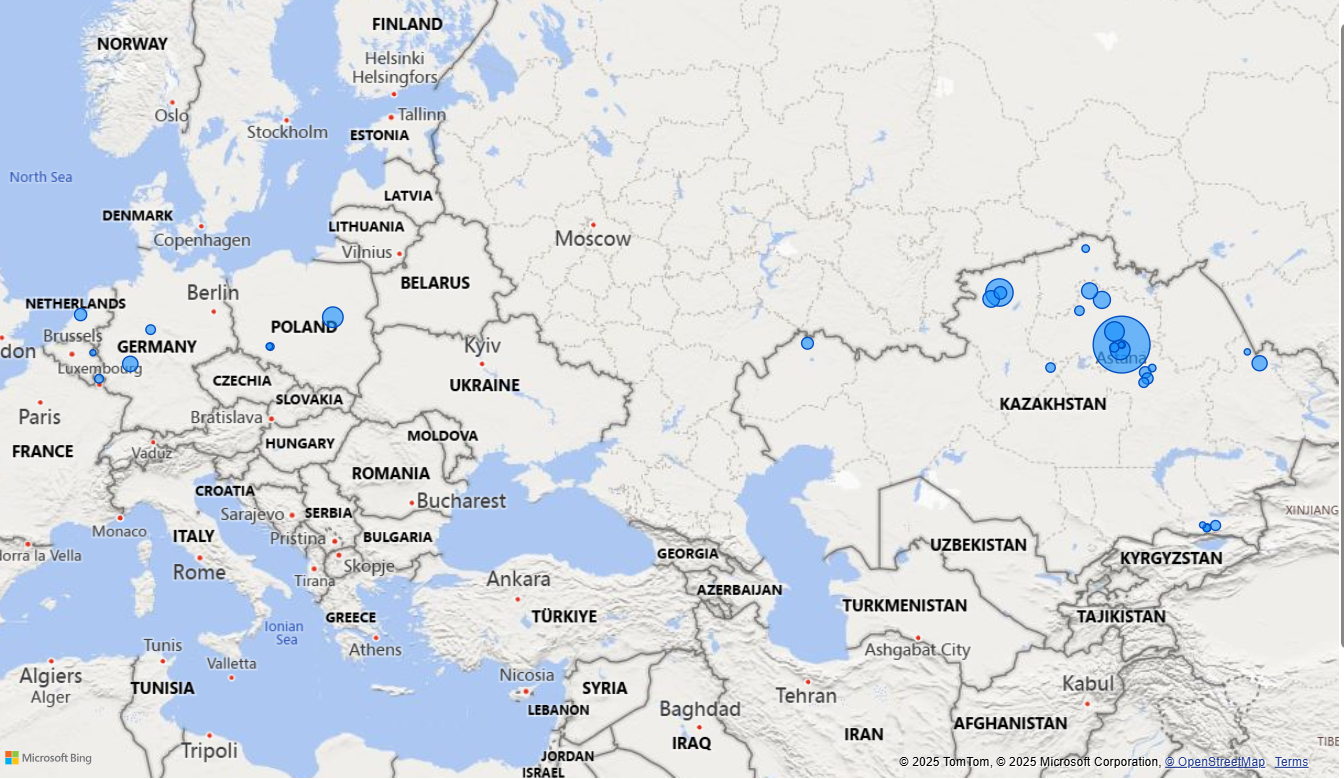

*Comment:* This map took aroud 3 days me to build. There was a lot of errors, especially with \copy and importing in PostgreSQL. A lot of new commands was interfered. I tried my best but at the end it failed. And there is nothing i can do

# Geomap Failed
Because ip_adresses was incorrect. The reason was the usage of vpn, especially in poland and germany as you may see. But vpn is not the only reason. IP address pools of ISPs(ip sometime show not my location, but the provider's), Lower accuracy of free database, Mobile networks(frequently assign IPs from a central hub city)

After the loss of some morall points i had to recover and continue my project, although failing after a lot of hours of trying was unpleasant. Anyway i learned a lot of new stuff

# Fifth Query
**Most listened tracks in a period of time with slicers for months**

In [ ]:
 WITH monthly AS (
         SELECT to_char(date_trunc('month'::text, streaming_history.ts), 'mon-yy'::text) AS month,
            streaming_history.track_name,
            round(sum(streaming_history.ms_played) / 3600000::numeric, 2) AS playtime,
            row_number() OVER (PARTITION BY (date_trunc('month'::text, streaming_history.ts)) ORDER BY (sum(streaming_history.ms_played) / 3600000::numeric) DESC) AS rn
           FROM streaming_history
          GROUP BY (date_trunc('month'::text, streaming_history.ts)), streaming_history.track_name
          ORDER BY (date_trunc('month'::text, streaming_history.ts)), (round(sum(streaming_history.ms_played) / 3600000::numeric, 2)) DESC
        )
 SELECT month,
    track_name,
    playtime,
    rn
   FROM monthly
  WHERE rn < 11;

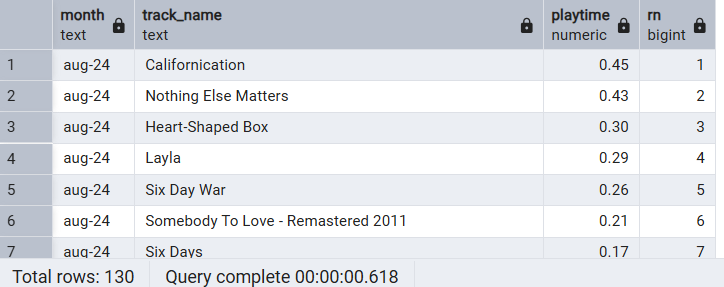

**Functions used:** subquery, window function, group by, date trunc, round, to char, date type conversion

**Insight:** The main insight i get is the my music progression. How my taste changed over time and how i discovered new genres/artists/songs. Also i can trace how much time i was spending listening to the music in different months

**Final Graph:**

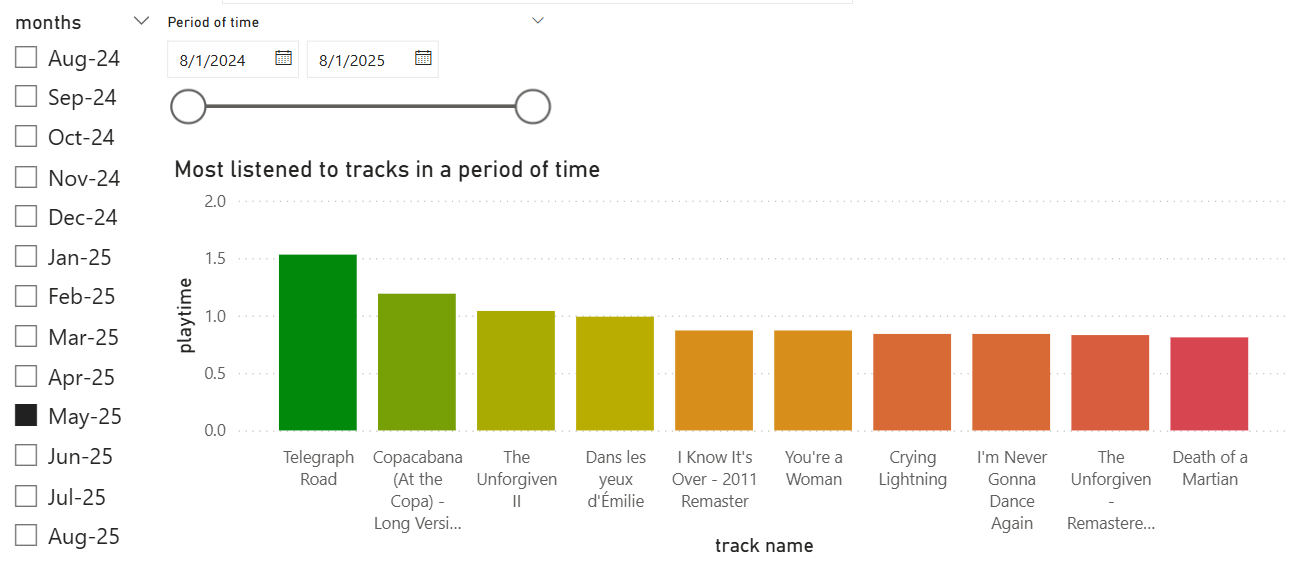

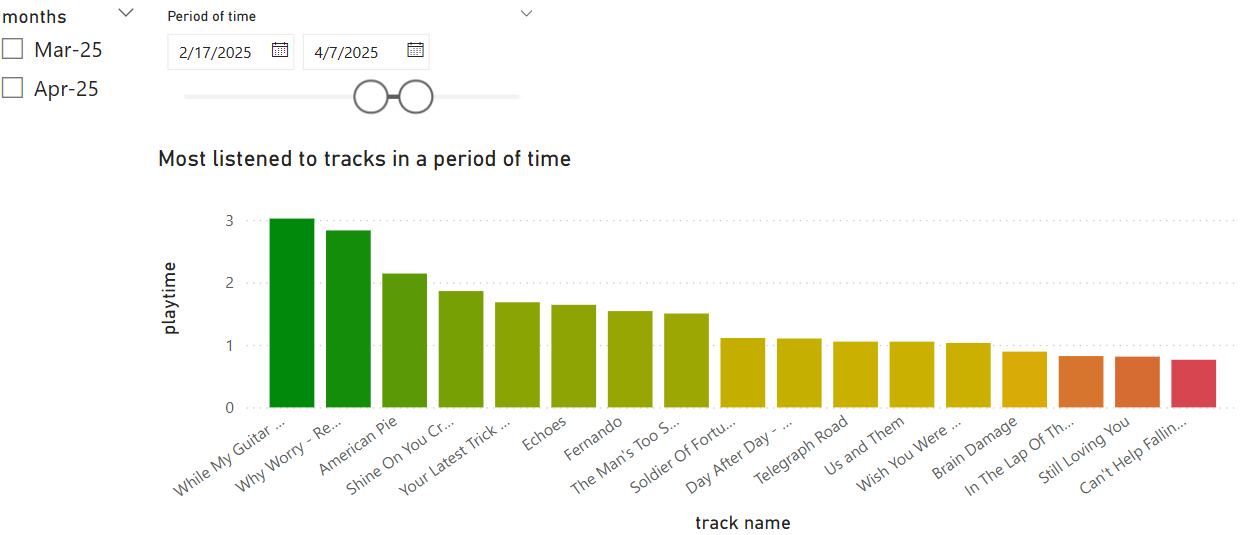

*Comment:* The color of the column represent how much i have listened across all the months. There is average value of hours for all 12 month(0.9, if the value is more graph is greener and if lower more red)

Most listened tracks in a period of time is perfect to track the music progression i have been following.
Lets compare aug 2024 and aug 2025

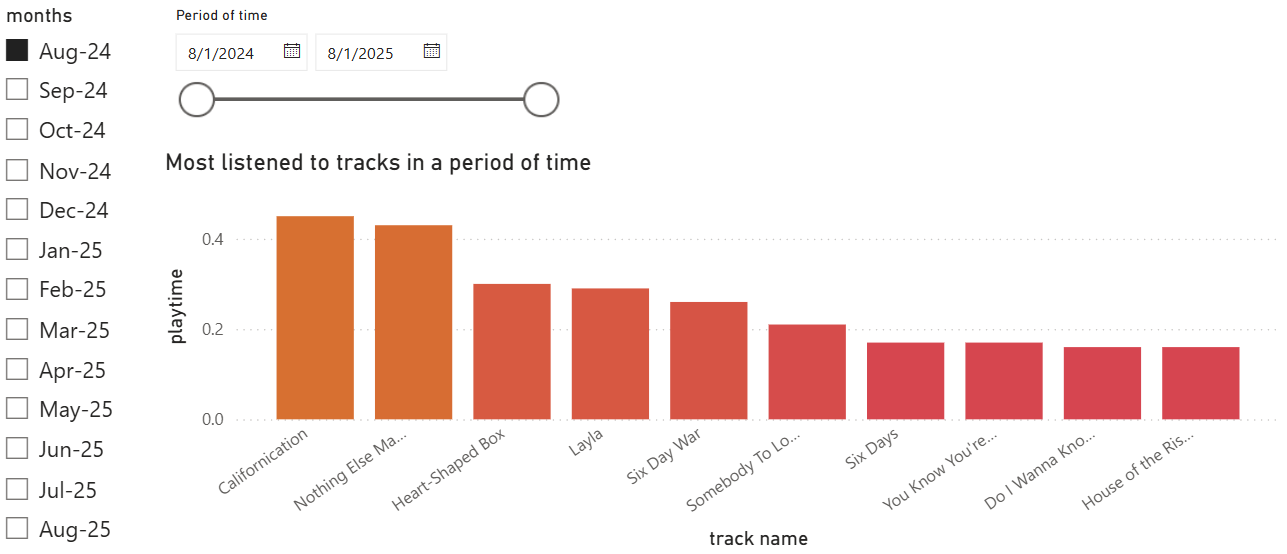

There we can see that 8 rock, 1 metal and 1 electronic songs and in comparison with other months playtime is low. Almost every of this songs is the most popular songs of their artists. Thats surface of the iceberg

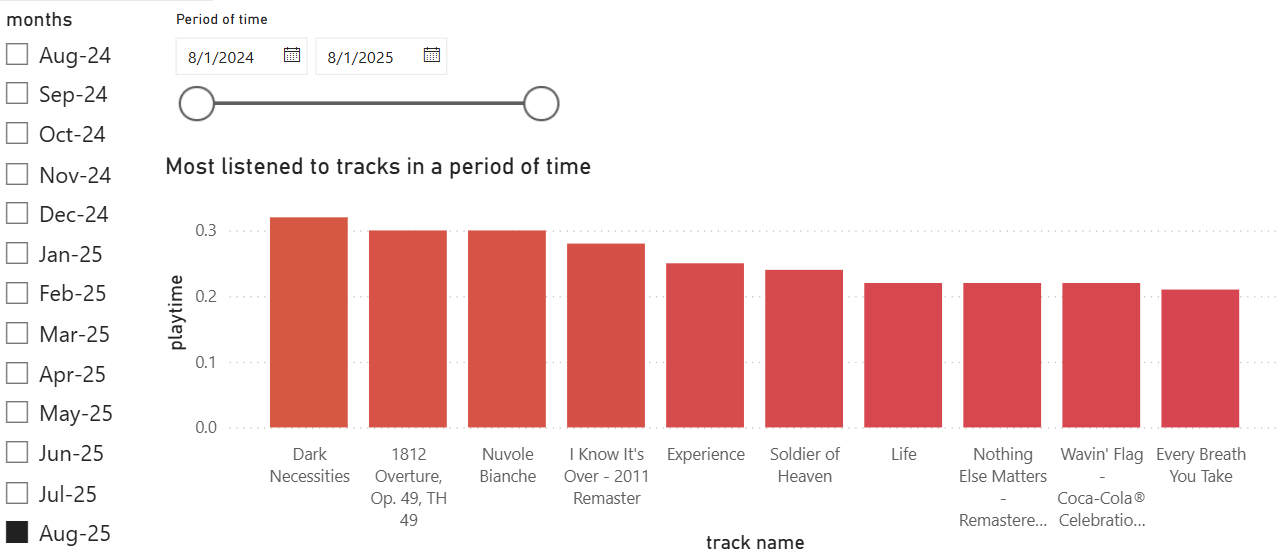

Now there is 2 rock, 2 metal, 3 pop/pop rock, 3 classical songs. Genre distrubition became diverse and more niche songs. Both of the augustus playtime is low, we can see the pattern. Its because at august i am preparing for new study year and not only. Thats my hub month, where i am preparing all the kinds of things, so i dont have much environment to listen to music. Now let's see month with the most playtime

In [ ]:
SELECT month, sum(playtime) FROM
(
 WITH monthly AS (
         SELECT to_char(date_trunc('month'::text, streaming_history.ts), 'mon-yy'::text) AS month,
            streaming_history.track_name,
            round(sum(streaming_history.ms_played) / 3600000::numeric, 2) AS playtime,
            row_number() OVER (PARTITION BY (date_trunc('month'::text, streaming_history.ts)) ORDER BY (sum(streaming_history.ms_played) / 3600000::numeric) DESC) AS rn
           FROM streaming_history
          GROUP BY (date_trunc('month'::text, streaming_history.ts)), streaming_history.track_name
          ORDER BY (date_trunc('month'::text, streaming_history.ts)), (round(sum(streaming_history.ms_played) / 3600000::numeric, 2)) DESC
        )
 SELECT month,
    track_name,
    playtime,
    rn
   FROM monthly
  WHERE rn < 11)
GROUP BY 1
ORDER BY 2 DESC

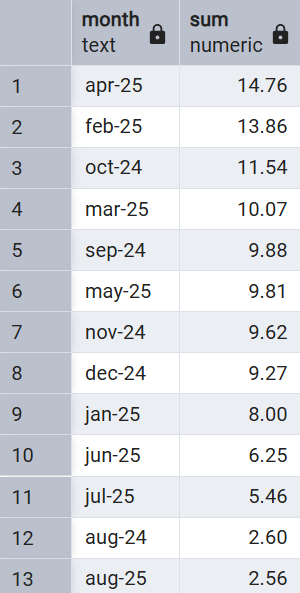

April 2025 is the leader in this chart, so lets look at it

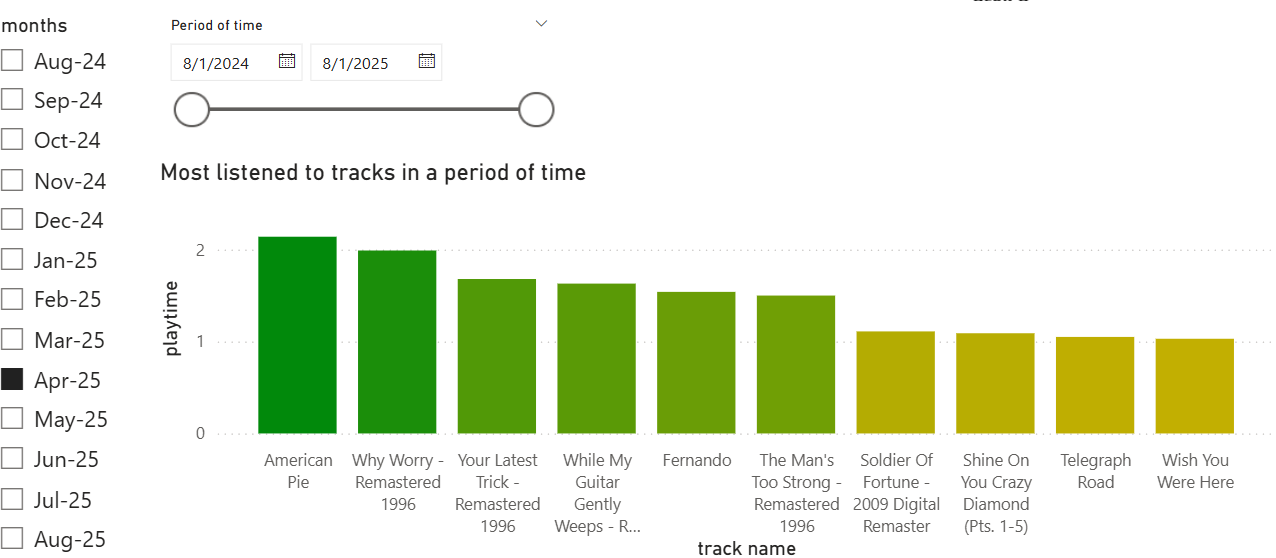

Two more patterns can be seen here. First is the duration of this songs. They all is long, especially:  
American Pie, Why Worry 8-9 minutes   
Shine On You Crazy Diamond(Pts. 1-5), Telegraph Road 13-14 minutes  
And the rest is 4+  
If we will find average of this 10, it will be 7 min 58 sec, which is pretty long  
In comparison august 2024 is 4 min 56 sec and august 2025 is 4 min 55 sec(cut overture cuz i always listen to 3-5 minutes of this song)  
**In conclusion** its obvious that the **average** duration of the songs we listen affect overall playtime
  
Now the second pattern is the season distribution. Let's draw a chart to better see it 

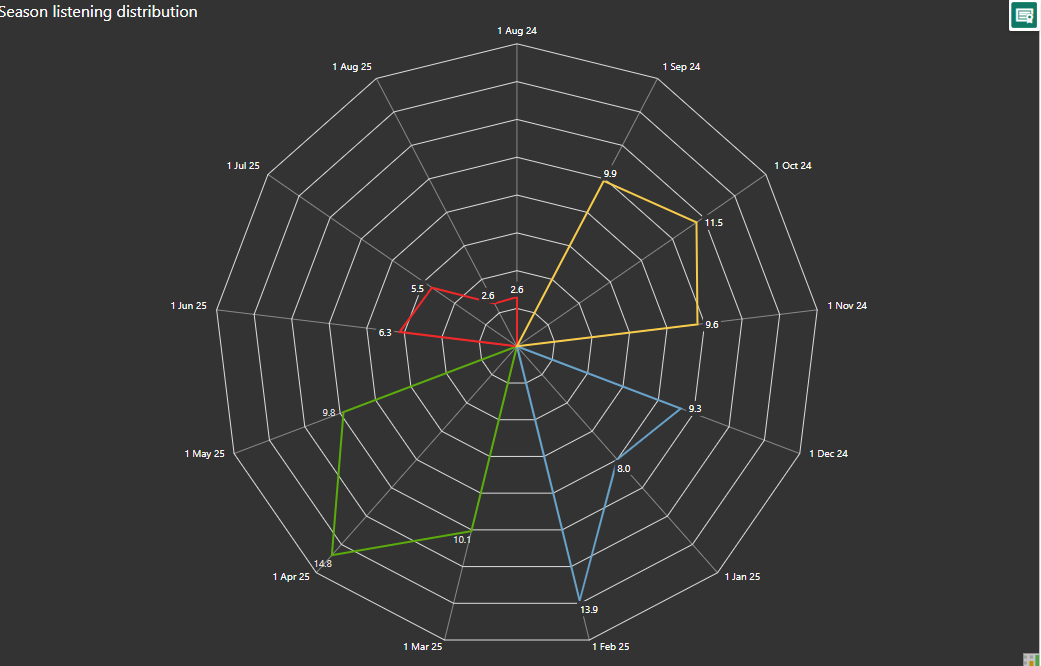

There we can see that overall summer is the outsider. Even with the additional august month(24, 25 years) is not near to the other months. The reason is high temparature that doesn't attract you to go outside and even if i hang out somewhere, i go with someone, so not much reason to listen to music. In the other hand winter, fall and spring is filled with routine walks. To the university or just go for a walk due to the pleasant temperature, except january, but it also get low playtime

Now let's track down when i discovered new genres. The first one is sep-24

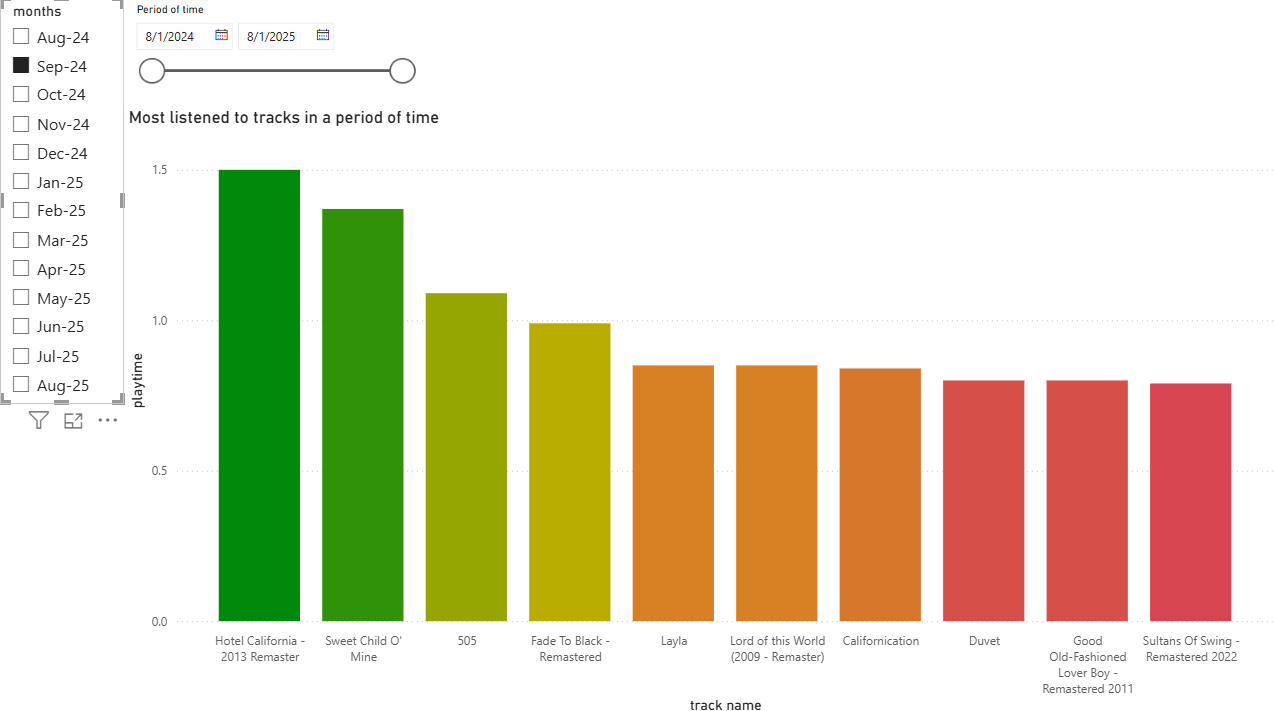

September opened me heavy metall with Black Sabbath, alt rock with Duvet and glam rock with Queen

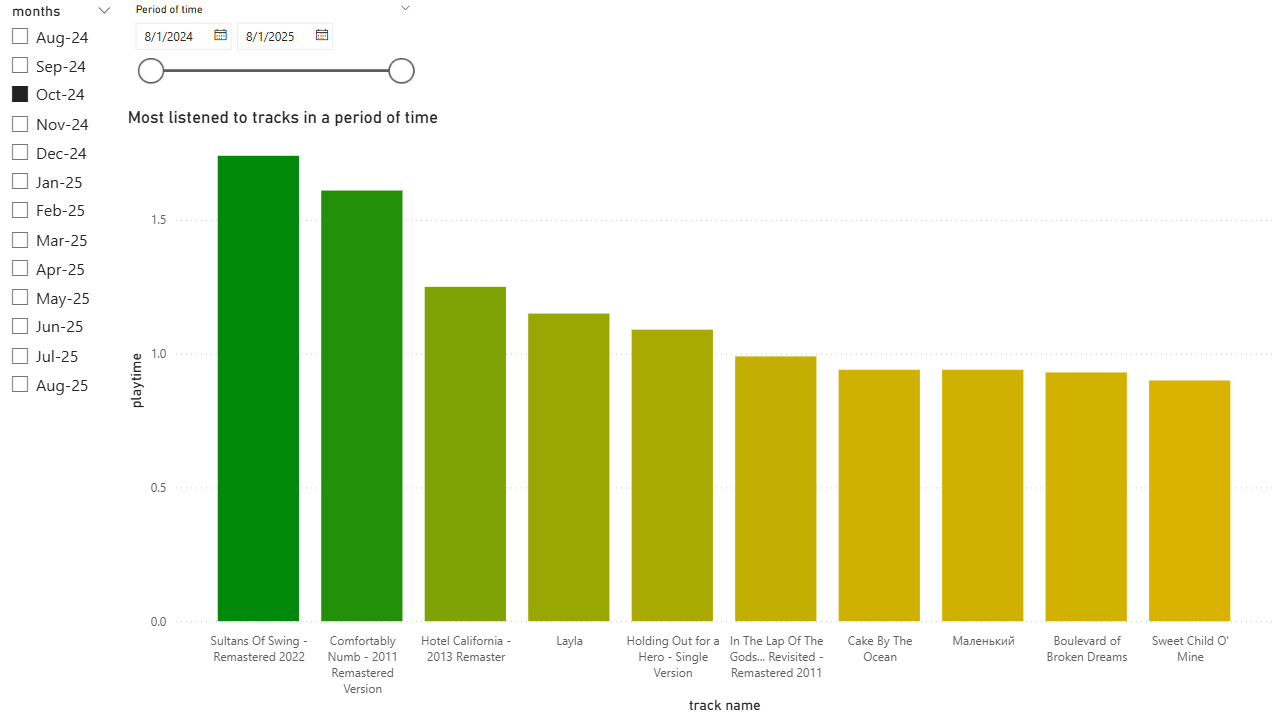

Comfortably Numb is prog rock song and looks like in october i discovered Pink Floyd. Next one is Jan-25

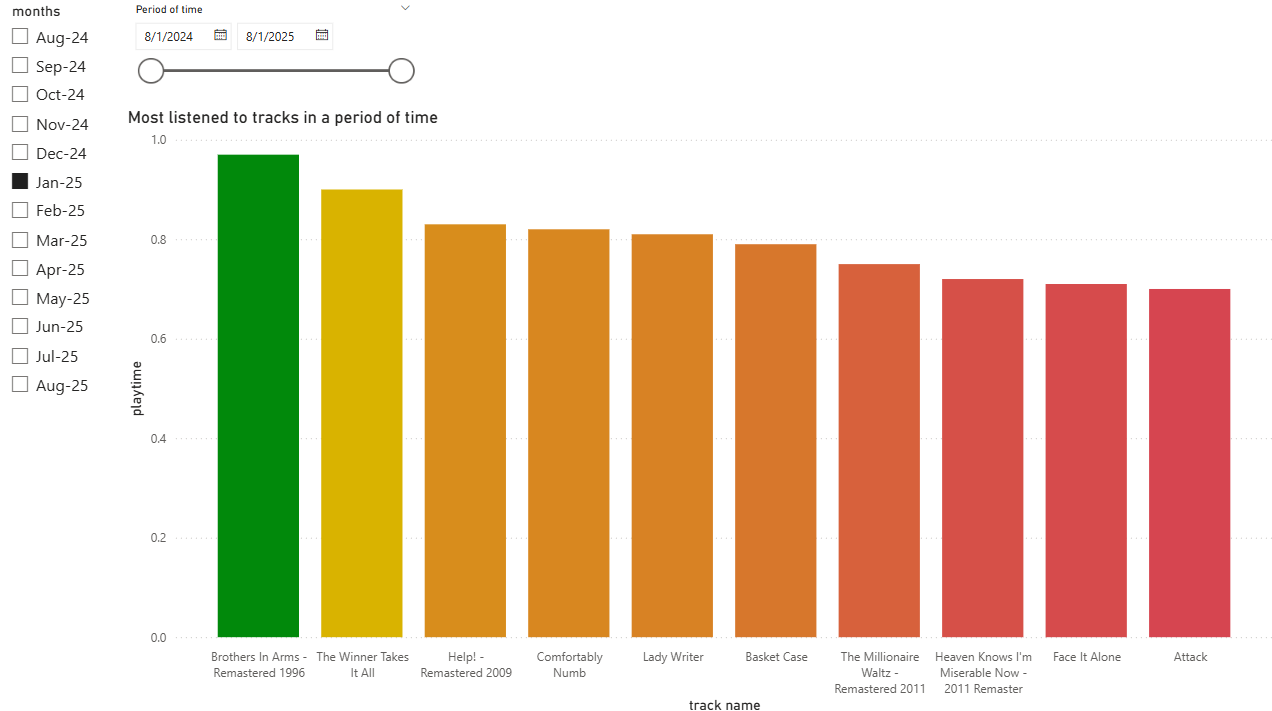

We can see Help! that gave start to my beatlomania and classical rock. Also there pop comes in with ABBA and NU Metal with System of a Down(Attack). Next one is Apr-25

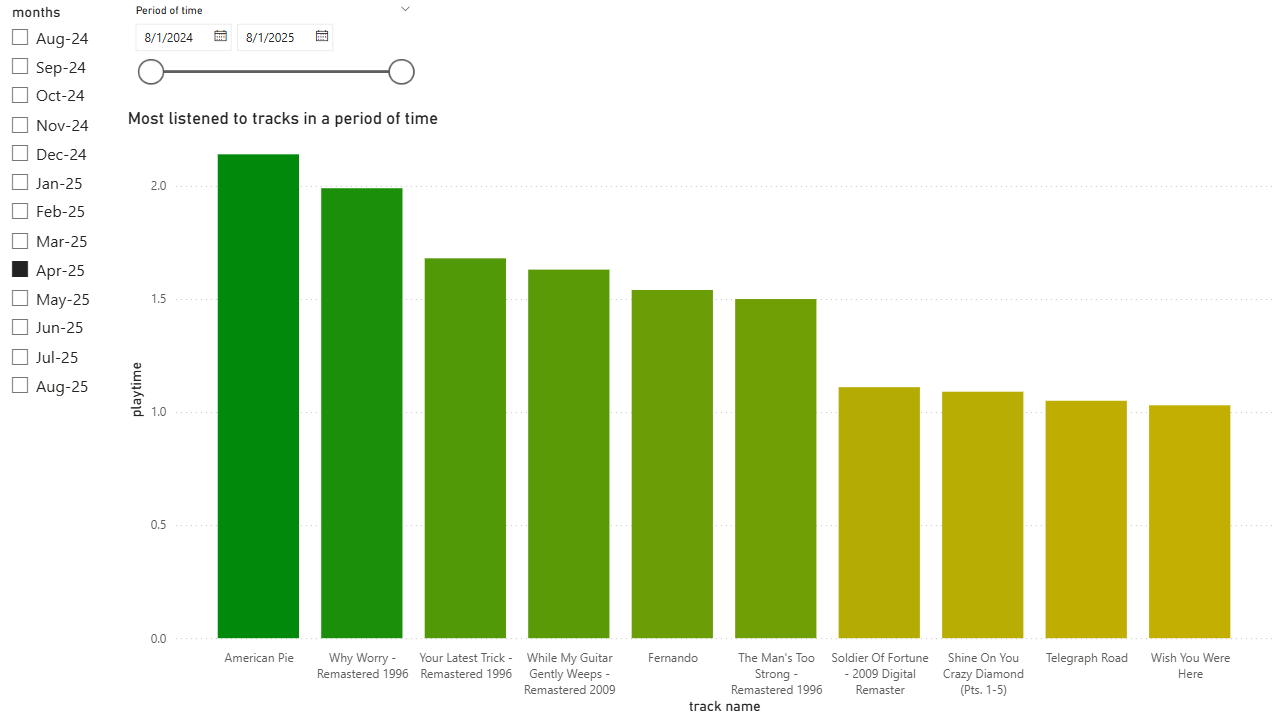

Your Latest Trick is jazz rock, Why Worry is blues rock, Telegraph Road is Folk. The Dire Straits inserts three new genres, thats why i love them so much. Next one is Jun-25

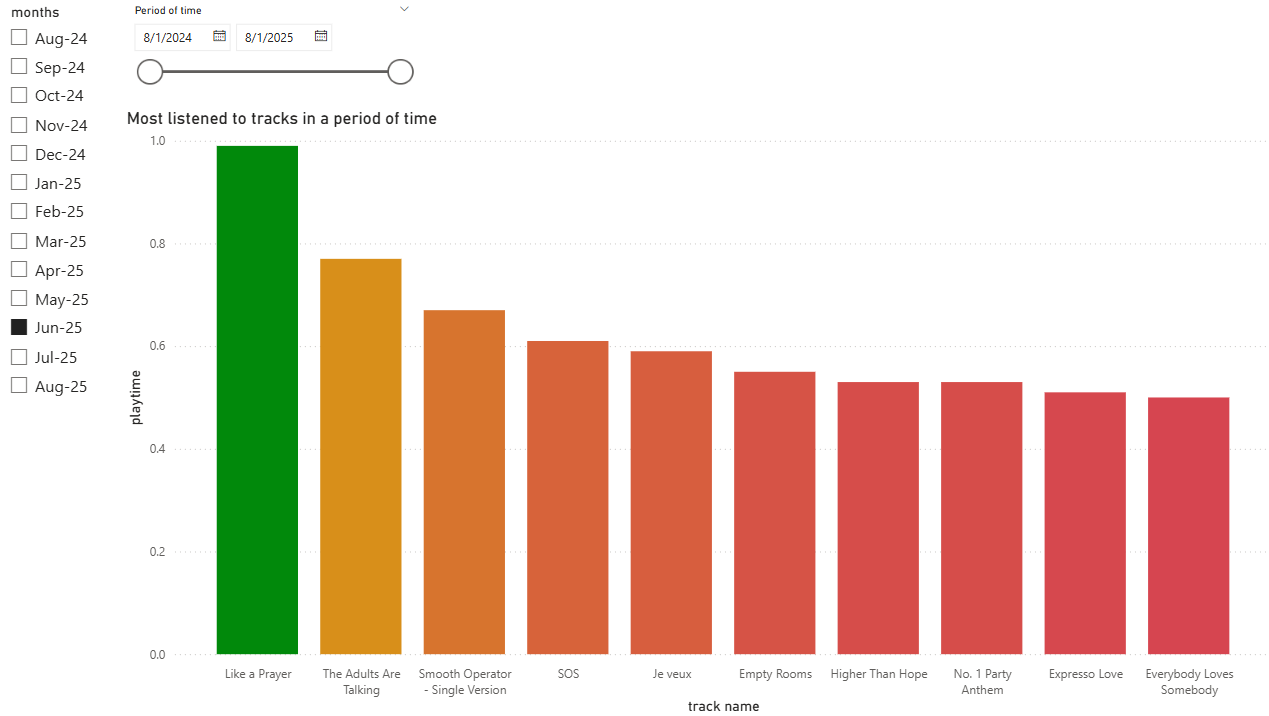

Pop rock/dance pop takes takes the first place. Smooth Operator is Jazz, Empty Rooms is Blues, Higher Than Hope is symphonic metal. This month has opened pure genres like Jazz and Blues. Next one is Jul-25

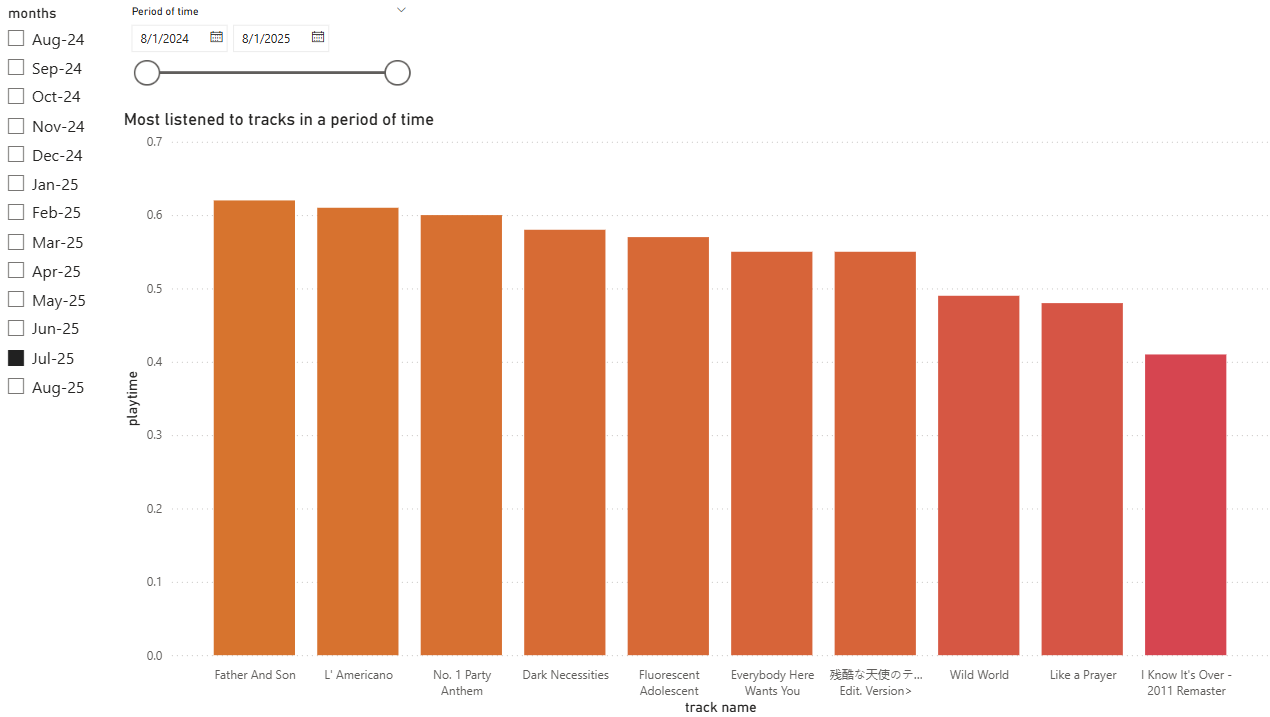

One more Folk song being Father And Son and even more jazz with L'Americano, japanes jazz with that 7 song. The last one is Aug-25

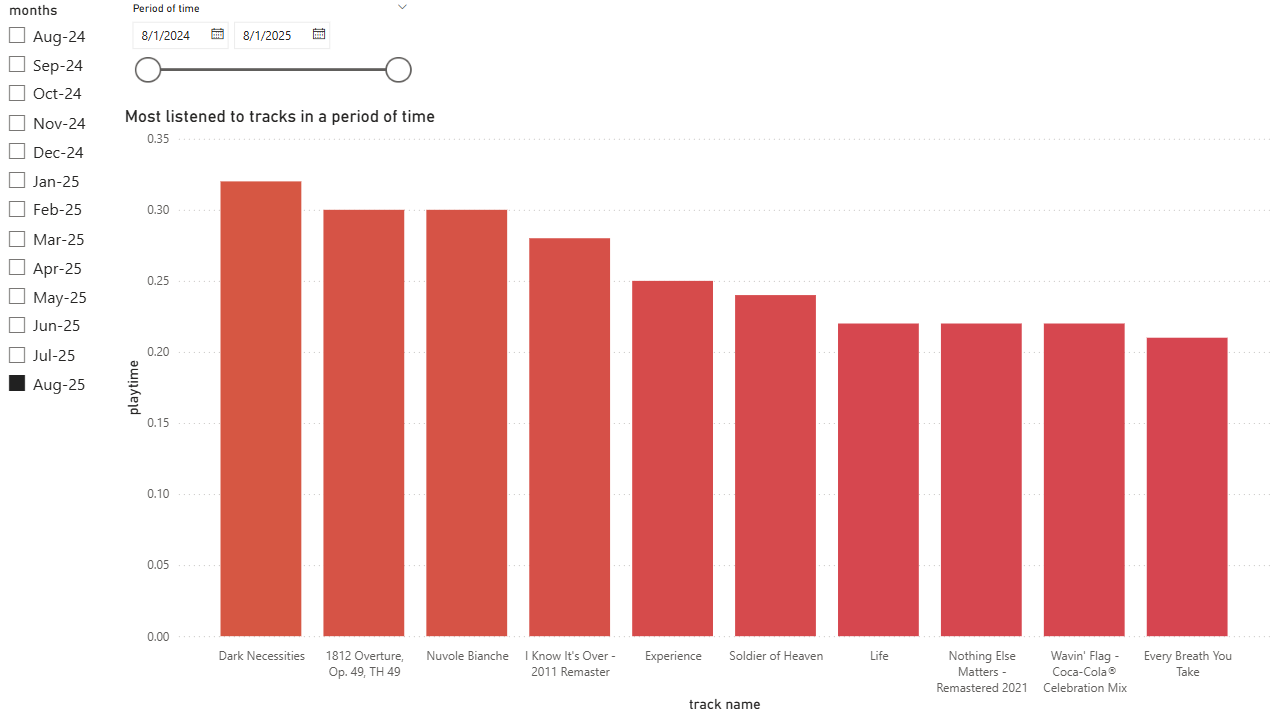

Classical music comes in with 1812 Overture, Neo-Classical with Nuvole Biance, Experience and Life

# Conclusion
*What i learned:*  
  
**SQL/PYTHON:** importing json data using psycopg2, jsonb, handling raw data, data type conversions, window functions, practiced subqueries, transforming ip to integer, learned about ipv4 and ipv6, importing data using pandas, indexes, psql(\copy command), CTE, to_char, creating views  
  
**Power BI:** importing data, transforming data using Power Query, clustered bar chart, funnel,  line stacked column chart, building map, clustered column chart, slicers, radar chart, importing new charts into Power BI

# Final insights
Genre discovery:
Heavy Metall, Glam Rock - September 2024  
Progressive Rock - October 2024  
Classic Rock, Pop, NU Metal - January 2025  
Jazz Rock, Blues Rock, Folk - April 2025  
Pop Rock, Dance Pop, Jazz, Blues, Simphonic Metal - June 2025  
Classical, Neo-Classical - August 2025  
  
Hotel California being the most listened was unexpected to me. Sometimes we cant even report ourselves how much time we spend on something. That concerns almost every song on the top. If i would build the most listened songs by how i think it would be, the top would be totally different
  
Top skipped songs shows mostly overlistened songs. I love them all, but there are reason every of these song are in this top. Some of them has boring parts, unique mood that applies only to rare moments or have been in my playlist so long that i already tired of them, but cant delete them, because how i appreciate them. For example Brothers In Arms is such a masterpiece, but pacing is really slow. Not in a bad way, but slowly walking mood with slow start not always come together with the mood. Also this song was listened so much that i rarely listen to it and prefer to skip it
  
Most skipped songs after halfway shows the songs with boring/slow ending that not everyone wants to listen. It can be cut by this point(for me of course). Or maybe author could add new unique verse, because most of the time reason it gets skipped is the repetative melody for full period of song. So people just get bored